In [ ]:
from google.colab import auth
import gspread, textwrap, nltk, re
from google.auth import default
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# GET DATA FROM GOOGLE SHEETS
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('refactor_code_review').sheet1
rows = worksheet.get_all_values()
pd.DataFrame.from_records(rows)

df_all = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df_selected = df_all[['subject', 'description', 'Category']]
print(df_selected.head())

                                        subject  \
0                         Refactoring log utils   
1                         Refactoring log utils   
2  (WIP) Refactor for better connection testing   
3  (WIP) Refactor for better connection testing   
4                Refactor project instance test   

                                         description   Category  
0  Refactoring log utils  * Moved log functions f...    testing  
1  Refactoring log utils  * Moved log functions f...  objective  
2  (WIP) Refactor for better connection testing  ...    testing  
3  (WIP) Refactor for better connection testing  ...  objective  
4  Refactor project instance test  Refactoring th...    testing  


In [ ]:
# MAKING IT MORE READABLE
df_limited = df_selected.head(10)
styled_df = df_limited.style.set_properties(**{'background-color': 'lightgrey', 'color': 'black', 'border-color': 'white'})
styled_df

,subject,description,Category
0,Refactoring log utils,Refactoring log utils * Moved log functions from rally/common/utils.py #L137-L234 to rally/common/log.y * Moved test tunctions form test/unit/common/test_utils.py to test/unit/common/test_log.py Change-Id: I9da0124d5a644fccb6e6253951321a61ec973b03,testing
1,Refactoring log utils,Refactoring log utils * Moved log functions from rally/common/utils.py #L137-L234 to rally/common/log.y * Moved test tunctions form test/unit/common/test_utils.py to test/unit/common/test_log.py Change-Id: I9da0124d5a644fccb6e6253951321a61ec973b03,objective
2,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing * Assign configured fake connections to test class dynamically * Generalize event queue handling in tests * Pass upstream_root to fake gerrit explicitly * Don't pass fake_gerrit to FakeURLOpener Change-Id: Icbe206db6bcbaaf78a3d89997f382c02079116c0,testing
3,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing * Assign configured fake connections to test class dynamically * Generalize event queue handling in tests * Pass upstream_root to fake gerrit explicitly * Don't pass fake_gerrit to FakeURLOpener Change-Id: Icbe206db6bcbaaf78a3d89997f382c02079116c0,objective
4,Refactor project instance test,Refactor project instance test Refactoring the test_launch_instance_post test as suggested in review for bug 1260436. There are four distinct other users of test_launch_instance_post apart from the test itself. Creating a new method _test_launch_instance_post and ensuring test_launch_instance_post now invokes this method with the default and only required parameters. Other tests also incoke the new method with parameters specific to them. Closes bug: #1403948 Change-Id: I5d2272a0abb521ddb9b1df215d45655a9049d0e0,testing
5,Refactor project instance test,Refactor project instance test Refactoring the test_launch_instance_post test as suggested in review for bug 1260436. There are four distinct other users of test_launch_instance_post apart from the test itself. Creating a new method _test_launch_instance_post and ensuring test_launch_instance_post now invokes this method with the default and only required parameters. Other tests also incoke the new method with parameters specific to them. Closes bug: #1403948 Change-Id: I5d2272a0abb521ddb9b1df215d45655a9049d0e0,objective
6,refactoring nova ha system tests to use neutron network manager,refactoring nova ha system tests to use neutron network manager *Changed nova-network-manager to neutron-tun on next test cases: - Add and re-add cinder / compute + cinder to HA cluster - Add compute node to cluster in HA mode with flat nova-network - Check HA mode on scalability - Backup/restore master node with cluster in ha mode - Optimize code by change repetable code to functions * Move neutron_tun cases to new file * Move neutron_public_network cases to new file Change-Id: Iedca3581bb1f9e0607a26afefd44a89a668fde99 Related-Bug:#1478787,testing
7,refactoring nova ha system tests to use neutron network manager,refactoring nova ha system tests to use neutron network manager *Changed nova-network-manager to neutron-tun on next test cases: - Add and re-add cinder / compute + cinder to HA cluster - Add compute node to cluster in HA mode with flat nova-network - Check HA mode on scalability - Backup/restore master node with cluster in ha mode - Optimize code by change repetable code to functions * Move neutron_tun cases to new file * Move neutron_public_network cases to new file Change-Id: Iedca3581bb1f9e0607a26afefd44a89a668fde99 Related-Bug:#1478787,objective
8,refactoring nova ha system tests to use neutron network manager,refactoring nova ha system tests to use neutron network manager *Changed nova-network-manager to neutron-tun on next test cases: - Add and re-add cinder / compute + cinder to HA cluster - Add compute node to cluster in HA mode with flat nova-network - Check HA mode on scalability -

In [ ]:
# TOKENIZE
df_selected = df_all[['subject', 'description', 'Category']].copy()  # Adding .copy() makes df_selected a separate DataFrame
df_selected['tokens'] = df_selected['description'].apply(lambda x: word_tokenize(x))
print(df_selected.head())

                                        subject  \
0                         Refactoring log utils   
1                         Refactoring log utils   
2  (WIP) Refactor for better connection testing   
3  (WIP) Refactor for better connection testing   
4                Refactor project instance test   

                                         description   Category  \
0  Refactoring log utils  * Moved log functions f...    testing   
1  Refactoring log utils  * Moved log functions f...  objective   
2  (WIP) Refactor for better connection testing  ...    testing   
3  (WIP) Refactor for better connection testing  ...  objective   
4  Refactor project instance test  Refactoring th...    testing   

                                              tokens  
0  [Refactoring, log, utils, *, Moved, log, funct...  
1  [Refactoring, log, utils, *, Moved, log, funct...  
2  [(, WIP, ), Refactor, for, better, connection,...  
3  [(, WIP, ), Refactor, for, better, connection,...  
4  [Refactor, p

In [ ]:
# REMOVE STOP WORDS
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Ensure you're operating on a copy to avoid SettingWithCopyWarning if df_selected is a slice
df_selected_modified = df_selected.copy()

# Tokenize and remove stopwords using .loc for safe assignment
for index, row in df_selected_modified.iterrows():
    tokens = word_tokenize(row['description'].lower())  # Tokenize and convert to lower case
    filtered_tokens = remove_stopwords(tokens)  # Remove stopwords
    df_selected_modified.loc[index, 'tokens'] = filtered_tokens

print(df_selected_modified.head())

                                        subject  \
0                         Refactoring log utils   
1                         Refactoring log utils   
2  (WIP) Refactor for better connection testing   
3  (WIP) Refactor for better connection testing   
4                Refactor project instance test   

                                         description   Category  \
0  Refactoring log utils  * Moved log functions f...    testing   
1  Refactoring log utils  * Moved log functions f...  objective   
2  (WIP) Refactor for better connection testing  ...    testing   
3  (WIP) Refactor for better connection testing  ...  objective   
4  Refactor project instance test  Refactoring th...    testing   

                                              tokens  
0  [refactoring, log, utils, *, moved, log, funct...  
1  [refactoring, log, utils, *, moved, log, funct...  
2  [(, wip, ), refactor, better, connection, test...  
3  [(, wip, ), refactor, better, connection, test...  
4  [refactor, p

In [ ]:
# LEMMATIZE
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

if 'lemmatized_tokens' not in df_selected_modified.columns:
    df_selected_modified['lemmatized_tokens'] = None  # Initialize the column with None

df_selected_modified['lemmatized_tokens'] = df_selected_modified['lemmatized_tokens'].astype(object)

for index, row in df_selected_modified.iterrows():
    lemmatized_tokens = lemmatize_tokens(row['tokens'])
    df_selected_modified.at[index, 'lemmatized_tokens'] = lemmatized_tokens

print(df_selected_modified.head())

                                        subject  \
0                         Refactoring log utils   
1                         Refactoring log utils   
2  (WIP) Refactor for better connection testing   
3  (WIP) Refactor for better connection testing   
4                Refactor project instance test   

                                         description   Category  \
0  Refactoring log utils  * Moved log functions f...    testing   
1  Refactoring log utils  * Moved log functions f...  objective   
2  (WIP) Refactor for better connection testing  ...    testing   
3  (WIP) Refactor for better connection testing  ...  objective   
4  Refactor project instance test  Refactoring th...    testing   

                                              tokens  \
0  [refactoring, log, utils, *, moved, log, funct...   
1  [refactoring, log, utils, *, moved, log, funct...   
2  [(, wip, ), refactor, better, connection, test...   
3  [(, wip, ), refactor, better, connection, test...   
4  [refact

In [ ]:
# UNIQUE TOKENS
unique_tokens = set()

# Iterate over each description, tokenize it, and update the set of unique tokens
for description in df_selected_modified['description']:
    tokens = word_tokenize(description)
    unique_tokens.update(tokens)

# Convert the set back to a list if you need a list format
unique_tokens_list = list(unique_tokens)

print(f"Unique tokens found: {len(unique_tokens_list)}")
print(unique_tokens_list)

Unique tokens found: 12398
['duplication', 'Warning', 'LocalBlockImage', 'paramater', 'Orders', 'I5e8423722416ea31fdced4c932ed141de90028ab', 'generically', 'create_export', '_make_fake_vdi', 'devide', 'service_resources.py', 'Garbutt', 'management', 'iptables-save', 'extra_spec', 'Specifications', 'Ief8ad621dba130701d7df4f8f5afbd92ed05ed4b', 'Pulled', 'inlined', 'test_backend.IdentityTests', '_resource_name', 'ostf', 'flagging', 'oswl', '==', '_get_docstring', 'publishes', 'mac_address=', 'I645b48cc99bf7a64e796f63d11b7daf4fef227a2', '1192924', 'throwing', 'Was', 'base.py', 'db.pp', 'nose', 'I7f538a900550d44efda3b7ea7c1be6132957e866', 'hope', '18.04', 'If2d2554f3509d3da7a6b625fd900d2090a3fe0f2', 'affects', 'powervm_sea_agent', 'kind', 'Said', 'methods.The', 'proxy.controller.obj.PUT', 'controller', 'drastically', 'manager.NetworkScenarioTest', 'subnets', '43:4', 'sequence', 'requirement', 'database', 'Deleted', 'tarballs', 'encoded', 'account_func', '71', 'get_hostname', 'AggregateTests

In [ ]:
# EXCLUDING UNUSUAL TOKENS i.e. "Iaddb1f096a4a085f08b83e3c86c3910b7e26f40a"
word_pattern = re.compile("^[A-Za-z]+('[A-Za-z]+)?$")

unique_tokens = set()

for description in df_selected['description']:
    tokens = word_tokenize(description)
    filtered_tokens = [token for token in tokens if word_pattern.match(token)]
    unique_tokens.update(filtered_tokens)

unique_tokens_list = list(unique_tokens)

print(f"Unique tokens found: {len(unique_tokens_list)}")
print(unique_tokens_list)

Unique tokens found: 6693
['duplication', 'Warning', 'LocalBlockImage', 'paramater', 'Orders', 'generically', 'devide', 'Garbutt', 'management', 'inlined', 'Specifications', 'Pulled', 'ostf', 'flagging', 'oswl', 'publishes', 'throwing', 'Was', 'nose', 'hope', 'affects', 'kind', 'Said', 'controller', 'drastically', 'subnets', 'sequence', 'requirement', 'database', 'Deleted', 'tarballs', 'encoded', 'AggregateTests', 'hack', 'gits', 'been', 'convoluted', 'memcache', 'tempurl', 'Most', 'fairly', 'respects', 'After', 'advantage', 'mocking', 'grown', 'andreas', 'Classes', 'lifecycle', 'broader', 'giving', 'conflict', 'VM', 'crypt', 'bloat', 'succeed', 'passhtru', 'CLI', 'conventional', 'guid', 'Provider', 'transactions', 'simulate', 'weights', 'software', 'segments', 'Correctly', 'Addresses', 'Ryan', 'ACLs', 'confusing', 'pxe', 'Likewise', 'Rifenbark', 'obj', 'Zanata', 'follow', 'selected', 'Require', 'documented', 'ClientManager', 'string', 'achieved', 'Scanner', 'outputs', 'cosmetic', 'rea

In [ ]:
# LOWERCASED & DE-DUPED
lowercased_unique_tokens = {token.lower() for token in unique_tokens_list}
lowercased_unique_tokens_list = list(lowercased_unique_tokens)
print(f"Unique tokens found: {len(lowercased_unique_tokens_list)}")
print(lowercased_unique_tokens_list)

Unique tokens found: 5697
['duplication', 'uploading', 'paramater', 'testmoveclaim', 'generically', 'tgtadm', 'devide', 'management', 'inlined', 'ostf', 'flagging', 'oswl', 'publishes', 'taskexecution', 'throwing', 'pkiz', 'nose', 'hope', 'sqla', 'affects', 'kind', 'controller', 'drastically', 'subnets', 'sequence', 'requirement', 'database', 'tarballs', 'encoded', 'hack', 'gits', 'been', 'convoluted', 'memcache', 'tempurl', 'fairly', 'respects', 'advantage', 'mocking', 'grown', 'notifies', 'andreas', 'octavia', 'lifecycle', 'asyncprocess', 'broader', 'giving', 'conflict', 'crypt', 'bloat', 'succeed', 'passhtru', 'conventional', 'guid', 'transactions', 'simulate', 'weights', 'software', 'segments', 'confusing', 'pxe', 'pacha', 'obj', 'follow', 'selected', 'medium', 'documented', 'extensiondescriptor', 'replicatedobjectcontroller', 'string', 'achieved', 'outputs', 'cosmetic', 'readably', 'coexist', 'subclasses', 'paper', 'minimal', 'rollbacks', 'tbd', 'information', 'moment', 'aimed', '

In [ ]:
# REMOVE STOPWORDS AGAIN...
stop_words = set(stopwords.words('english'))
final_tokens = [token for token in lowercased_unique_tokens_list if token not in stop_words]
print(f"Filtered unique tokens count (excluding stopwords): {len(filtered_tokens)}")
print(final_tokens)

Filtered unique tokens count (excluding stopwords): 116
['duplication', 'uploading', 'paramater', 'testmoveclaim', 'generically', 'tgtadm', 'devide', 'management', 'inlined', 'ostf', 'flagging', 'oswl', 'publishes', 'taskexecution', 'throwing', 'pkiz', 'nose', 'hope', 'sqla', 'affects', 'kind', 'controller', 'drastically', 'subnets', 'sequence', 'requirement', 'database', 'tarballs', 'encoded', 'hack', 'gits', 'convoluted', 'memcache', 'tempurl', 'fairly', 'respects', 'advantage', 'mocking', 'grown', 'notifies', 'andreas', 'octavia', 'lifecycle', 'asyncprocess', 'broader', 'giving', 'conflict', 'crypt', 'bloat', 'succeed', 'passhtru', 'conventional', 'guid', 'transactions', 'simulate', 'weights', 'software', 'segments', 'confusing', 'pxe', 'pacha', 'obj', 'follow', 'selected', 'medium', 'documented', 'extensiondescriptor', 'replicatedobjectcontroller', 'string', 'achieved', 'outputs', 'cosmetic', 'readably', 'coexist', 'subclasses', 'paper', 'minimal', 'rollbacks', 'tbd', 'information'

In [ ]:
# BUILD DICTIONARY
token_document_indices = {token: [] for token in final_tokens}

for index, description in enumerate(df_selected['description']):
    tokens = word_tokenize(description.lower())
    for token in final_tokens:
        if token in tokens:
            token_document_indices[token].append(index)

In [ ]:
# PRINT DICTIONARY OF TOKENS AND DOCUMENTS
for token, indices in token_document_indices.items():
    print(f"{token}, {indices}")

Streaming output truncated to the last 5000 lines.
ovndbsvirtualfixedips, [2537, 2538]
vlan, [293, 294, 295, 908, 909, 2966, 2967, 2968]
api, [37, 38, 39, 69, 70, 73, 74, 86, 87, 88, 89, 101, 102, 106, 107, 132, 133, 161, 162, 169, 170, 171, 174, 175, 265, 293, 294, 295, 401, 402, 403, 421, 422, 423, 464, 465, 593, 594, 595, 596, 597, 598, 646, 647, 648, 660, 661, 662, 723, 724, 725, 783, 784, 785, 815, 816, 910, 911, 912, 963, 964, 968, 969, 970, 979, 980, 981, 982, 983, 984, 985, 986, 987, 1019, 1020, 1034, 1035, 1043, 1044, 1045, 1049, 1050, 1051, 1062, 1063, 1064, 1101, 1102, 1103, 1154, 1155, 1156, 1157, 1162, 1163, 1212, 1213, 1241, 1242, 1243, 1253, 1254, 1255, 1267, 1268, 1269, 1285, 1286, 1287, 1288, 1302, 1303, 1304, 1330, 1331, 1332, 1337, 1338, 1339, 1340, 1341, 1342, 1404, 1405, 1406, 1434, 1435, 1436, 1437, 1495, 1496, 1497, 1500, 1501, 1502, 1503, 1513, 1514, 1515, 1519, 1520, 1521, 1530, 1531, 1532, 1543, 1544, 1545, 1546, 1547, 1548, 1552, 1553, 1554, 1555, 1573, 1574,

In [ ]:
print(token_document_indices)

{'duplication': [52, 53, 150, 151, 508, 509, 510, 529, 530, 531, 532, 541, 542, 543, 544, 692, 693, 694, 716, 717, 726, 727, 728, 838, 839, 840, 859, 860, 861, 968, 969, 970, 1065, 1066, 1067, 1214, 1215, 1216, 1217, 1218, 1346, 1347, 1348, 1711, 1712, 1713, 1873, 1874, 1951, 1952, 1977, 1978, 2028, 2102, 2103, 2407, 2408, 2870, 2871, 2872, 2886, 2887, 2944, 2945, 2946, 2962, 2975, 2976, 3029, 3030, 3031, 3092, 3093, 3165, 3195, 3196, 3230, 3231, 3365, 3366, 3367, 3368, 3369, 3370, 3507, 3508, 3520, 3521, 3636, 3637], 'uploading': [3144, 3145], 'paramater': [2908, 2909, 2910, 2911], 'testmoveclaim': [676, 677, 678, 679], 'generically': [3371, 3372], 'tgtadm': [13, 14, 15, 1036, 1037, 1038, 1786, 1787, 1788], 'devide': [430, 431, 487, 488, 502, 503], 'management': [37, 38, 39, 401, 402, 403, 815, 816, 1513, 1514, 1515, 1581, 1582, 1583, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1982, 1983, 1984, 1985, 2021, 2142, 2143, 2314, 2315, 2361, 2362, 3227, 3258, 3453, 3454, 3455, 3525, 35

In [ ]:
# Inverting the key-value pairs
inverted_dict = {}

for key, values in token_document_indices.items():
    for value in values:
        if value in inverted_dict:
            inverted_dict[value].append(key)
        else:
            inverted_dict[value] = [key]

print(inverted_dict)

key = 2
value = inverted_dict.get(key, "Key not found")
print(value)
print(df_selected.iloc[key])

{52: ['duplication', 'pull', 'put', 'refactor', 'test', 'instead', 'functions', 'setup', 'code'], 53: ['duplication', 'pull', 'put', 'refactor', 'test', 'instead', 'functions', 'setup', 'code'], 150: ['duplication', 'check', 'unit', 'version', 'proves', 'command', 'refactor', 'test', 'replacelatestversion', 'checking', 'add', 'called', 'remove', 'comments', 'line', 'given', 'argument', 'code'], 151: ['duplication', 'check', 'unit', 'version', 'proves', 'command', 'refactor', 'test', 'replacelatestversion', 'checking', 'add', 'called', 'remove', 'comments', 'line', 'given', 'argument', 'code'], 508: ['duplication', 'testecduplicationobjcontroller', 'class', 'variable', 'setting', 'methods', 'ectestmixin', 'perhaps', 'attempts', 'cases', 'todo', 'item', 'call', 'refactoring', 'structure', 'refactor', 'understand', 'place', 'testobjcontroller', 'basetestobjcontroller', 'hence', 'testobjcontrollerecduplication', 'test', 'change', 'testecobjcontroller', 'gather', 'normal', 'better', 'make',

In [ ]:
# TOP 25 KEYS
top_tokens = sorted(token_document_indices, key=lambda k: len(token_document_indices[k]), reverse=True)[:25]
for token in top_tokens:
    print(f"'{token}' #{len(token_document_indices[token])}")

'refactor' #3013
'test' #1609
'tests' #1153
'code' #1121
'patch' #904
'use' #784
'refactoring' #781
'function' #734
'api' #704
'also' #598
'change' #592
'class' #572
'new' #566
'functions' #514
'method' #508
'make' #467
'add' #456
'unit' #449
'used' #436
'blueprint' #433
'refactors' #429
'instead' #408
'methods' #395
'bug' #387
'added' #386


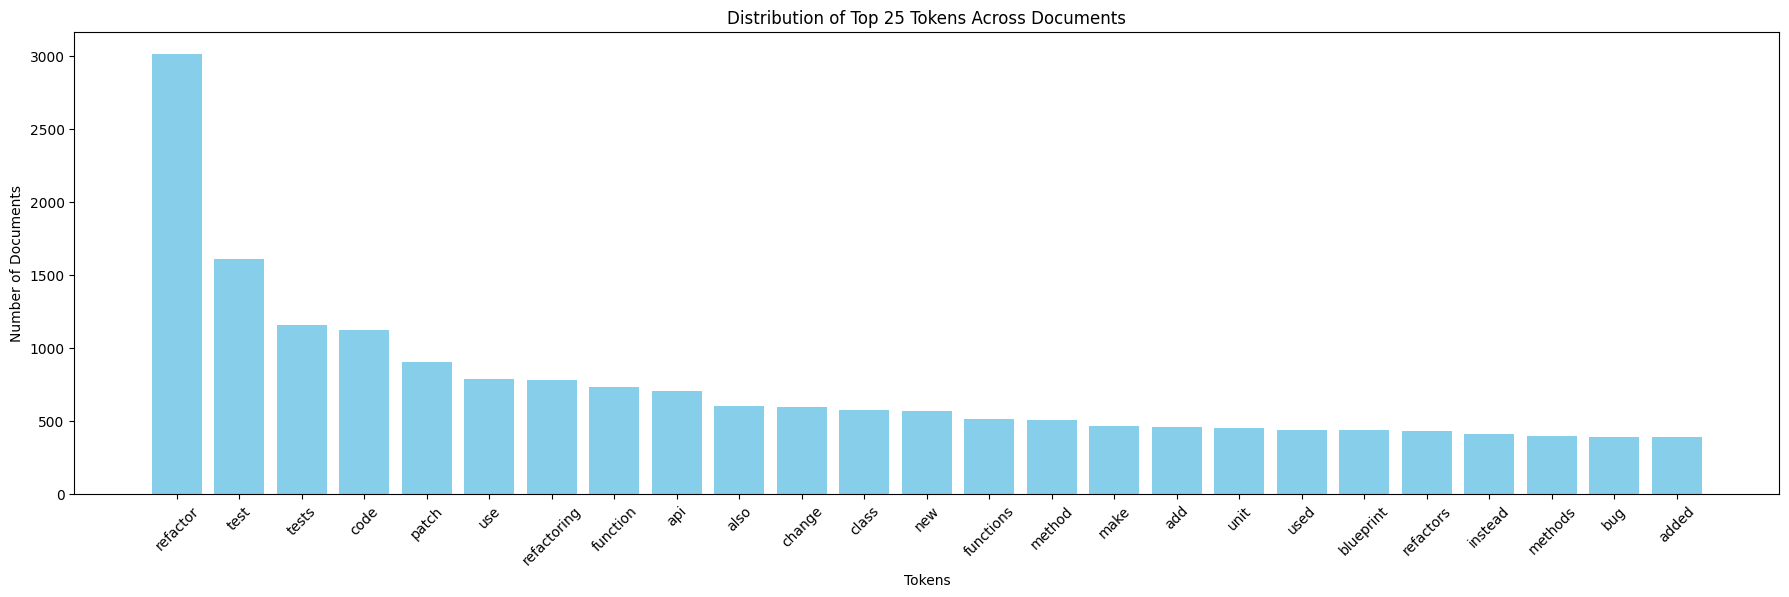

In [ ]:
tokens = list(token_document_indices.keys())
frequencies = [len(token_document_indices[token]) for token in tokens]

tokens_sorted, frequencies_sorted = zip(*sorted(zip(tokens, frequencies), key=lambda x: x[1], reverse=True))

N = 25
top_tokens = tokens_sorted[:N]
top_frequencies = frequencies_sorted[:N]

plt.figure(figsize=(22, 6))
plt.bar(top_tokens, top_frequencies, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Number of Documents')
plt.title('Distribution of Top {} Tokens Across Documents'.format(N))
plt.xticks(rotation=45)
plt.show()

In [ ]:
# CLUSTER
doc_strings = [" ".join(keywords) for doc_id, keywords in inverted_dict.items()]
n_clusters = 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(doc_strings)
kmeans = KMeans(n_clusters, random_state=42).fit(tfidf_matrix)
cluster_assignments = kmeans.labels_

doc_ids = list(inverted_dict.keys())
clusters_df = pd.DataFrame({'DocumentID': doc_ids, 'Cluster': cluster_assignments})
clusters_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DocumentID,Cluster
0,52,1
1,53,1
2,150,1
3,151,1
4,508,1


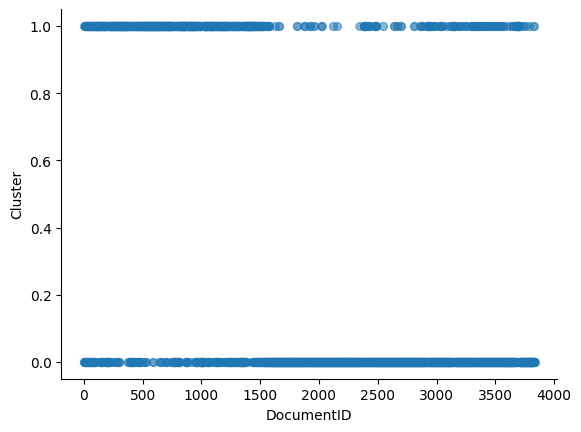

In [ ]:
# PRINT CLUSTERS
from matplotlib import pyplot as plt
clusters_df.plot(kind='scatter', x='DocumentID', y='Cluster', s=32, alpha=.3)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# DICTIONARY OF CLUSTERS
clusters = {}
for i, label in enumerate(kmeans.labels_):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(doc_ids[i])

print(clusters)
cluster = clusters.get(0)
print(cluster)
cluster_document = cluster[0]
print(cluster_document)

print(df_selected.loc[cluster_document]['subject'])
print(df_selected.loc[cluster_document]['description'])

{1: [52, 53, 150, 151, 508, 509, 510, 529, 530, 531, 532, 541, 542, 543, 544, 692, 693, 694, 716, 717, 726, 727, 728, 838, 839, 840, 859, 860, 861, 968, 969, 970, 1065, 1066, 1067, 1214, 1215, 1216, 1217, 1218, 1346, 1347, 1348, 2886, 2887, 3195, 3196, 676, 677, 678, 679, 13, 14, 15, 1036, 1037, 1038, 430, 431, 487, 488, 502, 503, 401, 402, 403, 815, 816, 3525, 3526, 3527, 1011, 1012, 1072, 1073, 971, 972, 973, 1031, 1032, 1033, 1235, 1236, 1237, 1238, 1222, 1223, 1224, 495, 496, 497, 835, 836, 837, 103, 104, 105, 908, 909, 940, 941, 942, 943, 976, 977, 978, 982, 983, 984, 985, 986, 987, 1099, 1100, 1101, 1102, 1103, 1319, 1320, 2024, 2025, 2384, 2385, 2386, 2387, 3338, 3339, 3427, 3428, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 101, 102, 979, 980, 981, 1083, 1084, 1085, 1186, 1187, 1188, 1198, 1199, 1200, 1201, 1267, 1268, 1269, 1292, 1293, 1294, 1386, 1387, 1388, 1434, 1435, 1436, 1437, 2344, 2345, 3123, 3124, 1088, 1089, 1090, 480, 481, 482, 122

In [ ]:
# RUN ONCE
df_labeled = df_selected.copy()

# CREATE NEW COLUMN
column_name = 'complexity'
if column_name not in df_labeled.columns:
    df_labeled[column_name] = None

In [ ]:
# LABELING FUNCTION
start = 1
flag = False
for i in range(start, n_clusters):
  cluster = clusters.get(i)
  if flag == True:
    print('stopping...')
    break
  for j in range(len(cluster)):
    cluster_document = cluster[j]
    print("DOC: ", cluster_document)
    print(df_labeled.loc[cluster_document]['subject'])
    print(textwrap.fill(df_labeled.loc[cluster_document]['description'], width=100))
    new_value = input(f" + ADD LABEL: ")
    if new_value == '0':
      flag = True
      break
    else:
      df_labeled.at[cluster_document, column_name] = new_value
      print(df_labeled.loc[cluster_document]['complexity'], "\n")

# PRINT NEW LABELS
print(df_labeled.columns)
complexity_counts = df_labeled['complexity'].value_counts()
print(complexity_counts)

DOC:  52
refactor out code duplication
refactor out code duplication  pull out the duplication of setup that was in all the test functions
and put it in setup instead.  Change-Id: I36cb64f326025fd29bdbb72b2e4130fb89326ad7
 + ADD LABEL: 
 

DOC:  53
refactor out code duplication
refactor out code duplication  pull out the duplication of setup that was in all the test functions
and put it in setup instead.  Change-Id: I36cb64f326025fd29bdbb72b2e4130fb89326ad7
 + ADD LABEL: 0
Index(['subject', 'description', 'Category', 'tokens', 'complexity'], dtype='object')
complexity
    1
Name: count, dtype: int64


In [ ]:
# SPLIT DATA INTO TRAINING DATA
# This is most likely beyond the scope of the paper.
df_train, df_test = train_test_split(df_labeled, test_size=0.2, random_state=42)
df_train, df_test

(                                                subject  \
 433                   Refactor scrubber functional test   
 1569           Refactor BMC provisioning in Maintenance   
 371               Refactor patches for haproxy package.   
 3267  Refactor functions which read astute yaml dire...   
 2298  Refactoring and removing duplicate code of "ba...   
 ...                                                 ...   
 1130         Refactor unit test code for disk pollsters   
 1294             Refactored fake connection URL classes   
 860      Refactor Nexus test code to remove duplication   
 3507   Refactor processing of testr artifacts for reuse   
 3174                    Monasca role refactoring[+docs]   
 
                                             description     Category  \
 433   [WIP]Refactor scrubber functional test  Refact...    objective   
 1569  Refactor BMC provisioning in Maintenance  The ...    objective   
 371   Refactor patches for haproxy package.  Use hap...  i

In [ ]:
# CREATE CLASSIFICATION MODEL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Preprocess the text data
X_train = df_train["description"].astype(str)
y_train = df_train["Category"].apply(lambda x: 1 if x == "refactoring" else 0)

X_test = df_test["description"].astype(str)
y_test = df_test["Category"].apply(lambda x: 1 if x == "refactoring" else 0)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert sparse matrices to dense representation
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build the feedforward neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_dense, y_test, verbose=0)
print(f'Test Accuracy: {accuracy}')

# Predict probabilities
y_pred_prob = model.predict(X_test_dense)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

Epoch 1/10
77/77 [==============================] - 2s 16ms/step - loss: 0.2634 - accuracy: 0.9295 - val_loss: 0.2723 - val_accuracy: 0.9560
Epoch 2/10
77/77 [==============================] - 1s 14ms/step - loss: 0.1483 - accuracy: 0.9552 - val_loss: 0.2637 - val_accuracy: 0.9560
Epoch 3/10
77/77 [==============================] - 1s 18ms/step - loss: 0.1169 - accuracy: 0.9552 - val_loss: 0.2751 - val_accuracy: 0.9560
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 0.0890 - accuracy: 0.9548 - val_loss: 0.2870 - val_accuracy: 0.9577
Epoch 5/10
77/77 [==============================] - 1s 15ms/step - loss: 0.0801 - accuracy: 0.9580 - val_loss: 0.3048 - val_accuracy: 0.9528
Epoch 6/10
77/77 [==============================] - 1s 14ms/step - loss: 0.0649 - accuracy: 0.9666 - val_loss: 0.3652 - val_accuracy: 0.9446
Epoch 7/10
77/77 [==============================] - 1s 14ms/step - loss: 0.0600 - accuracy: 0.9751 - val_loss: 0.3651 - val_accuracy: 0.9332
Epoch 8/10
77

In [ ]:
# CATEGORY IS OUR CLASSIFICATION
y_train_sub = y_train[y_train == 0]
y_test_sub = y_test[y_test == 0]
c = clusters[0]
print(c)
count = 0
for idx in y_train_sub.index:
  # print(idx)
  if idx in c:
    count += 1
for idx in y_test_sub.index:
  if idx in c:
    count += 1
print(count/len(c))

[1711, 1712, 1713, 1873, 1874, 1951, 1952, 1977, 1978, 2028, 2102, 2103, 2407, 2408, 2870, 2871, 2872, 2944, 2945, 2946, 2962, 2975, 2976, 3029, 3030, 3031, 3092, 3093, 3165, 3230, 3231, 3365, 3366, 3367, 3368, 3369, 3370, 3507, 3508, 3520, 3521, 3636, 3637, 3144, 3145, 2908, 2909, 2910, 2911, 3371, 3372, 1786, 1787, 1788, 37, 38, 39, 1513, 1514, 1515, 1581, 1582, 1583, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1982, 1983, 1984, 1985, 2021, 2142, 2143, 2314, 2315, 2361, 2362, 3227, 3258, 3453, 3454, 3455, 3578, 3632, 3633, 3634, 3635, 3776, 3777, 3778, 3373, 3374, 1005, 1006, 1007, 1013, 1014, 1015, 1016, 1017, 1018, 1375, 1376, 988, 989, 990, 2524, 2525, 2526, 2527, 2377, 2378, 3475, 3476, 3477, 69, 70, 2379, 2380, 873, 874, 875, 22, 23, 24, 3355, 3356, 3357, 1363, 1364, 1365, 1366, 2890, 3666, 3667, 3668, 3675, 3676, 3677, 2457, 2458, 9, 10, 11, 12, 2373, 2374, 1746, 1747, 1748, 1853, 1854, 1855, 2061, 2062, 3646, 3647, 435, 436, 437, 795, 796, 797, 915, 916, 1562, 1563, 1564, 

In [ ]:
# RQ1. Are there performance differences vs. Unsupervised and Supervised methods, when determining refactoring vs. non-refactoring commit messages?
# RQ2. Clustering vs. Classification Performance